In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 1
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

Using TensorFlow backend.


In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
cfg = local_import("./laptop.py")

In [4]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Loading word dictionary...
Shape of dictionary (3048821, 4)
Warning! Dropping some words from word list, please verify!
Dropping 1211
Shape of merged df (1000000, 33)
Selecting only questions with at least 5 meaningful words.
This removes 8582 questions.
Removing bad values with missing feature information.
This affects 19 questions.
Shape of answer df (2028240, 21)
Calculating normalized columns. They are available under usual column name + _norm.


In [5]:
data = cfg.data

In [6]:
data.keys()

['dbconn', 'meta', 'dict', 'features', 'answers']

In [7]:
qs = data["meta"];

In [8]:
qs.head()
print qs.shape

(991399, 54)


In [9]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

706703
386998


In [10]:
qs.columns
cols_desc

{'AnswerCount': 'Number of replies',
 'BodyNCodes': 'Number of code tags',
 'BodyNQMarks': 'Number of question marks',
 'BodySize': 'Length of post text',
 'Score': 'Question score',
 'nwords': 'Number of meaningful words',
 'ordermean': 'Word prevalence (average)',
 'orderstd': 'Word prevalence (std)',
 'ordersum': 'Word prevalence (sum)',
 'prob_bern': 'Joined bernoulli probability of words',
 'ratio': 'Ratio of number of verbs to nouns',
 'titlelen': 'Length of title'}

In [11]:
n_timecat = 4
timecat_bins = np.linspace(-0.5, n_timecat + 0.5, n_timecat + 2)

# training and testing samples
qs = shuffle(qs)
print "Length of the whole shuffled question df:", len(qs)
# limiting to questions with accepted answer for training

tmask = np.isfinite(qs.dt_accanswer_hour)
time_categories = mquantiles(qs.loc[tmask].dt_accanswer_hour, prob=np.linspace(0, 1, n_timecat + 1))
print "Bins for time categories", time_categories
qs["timecat"] = 0
qs.loc[tmask, "timecat"] = np.digitize(qs.loc[tmask].dt_accanswer_hour, time_categories) - 1
qs.loc[~tmask, "timecat"] = n_timecat

qssel = qs[tmask]
qssel = qssel.append(qs[~tmask].iloc[:int(len(qssel) * 1. / (len(time_categories) - 1))])
qssel = shuffle(qssel)

train = 250000
qstrain = qssel.iloc[:train]
qstest = qssel.iloc[train:]
print "Length of the training set:", len(qstrain)
print "Length of the testing set:", len(qstest)

# label = "dt_accanswer_hour"
label = "timecat"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print "Number of questions without answer:", len(qsnone)

Length of the whole shuffled question df: 991399
Bins for time categories [  0.00000000e+00   1.89288000e-01   6.78036000e-01   5.45282520e+00
   5.47461192e+03]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Length of the training set: 250000
Length of the testing set: 233747
Number of questions without answer: 284672


In [12]:
time_categories

array([  0.00000000e+00,   1.89288000e-01,   6.78036000e-01,
         5.45282520e+00,   5.47461192e+03])

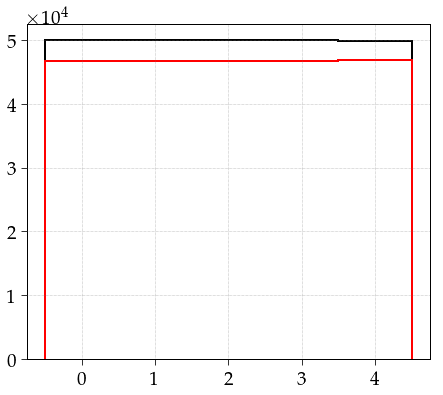

In [12]:
plt.figure(figsize=(8, 6))
qstrain.timecat.hist(color="k", lw=2, histtype="step", bins=timecat_bins)
qstest.timecat.hist(color="red", lw=2, histtype="step", bins=timecat_bins)

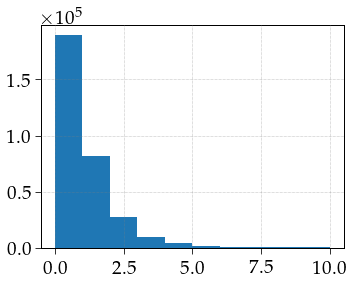

In [16]:
qstrain.Score.hist(bins=10, range=[0,10]);

In [13]:
qstrain.Score.describe()

count    250000.000000
mean          0.519272
std           2.308789
min         -59.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         427.000000
Name: Score, dtype: float64

In [14]:
qstrain.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordermean', u'orderstd', u'ordersum', u'prob_bern', u'prob_poiss',
       u'ratio', u'ParentId_first', u'CreationDate_first', u'Id_acc',
       u'CreationDate_acc', u'dayhour', u'weekday', u'day', u'dt_answer',
       u'dt_accanswer', u'dt_answer_hour', u'dt_accanswer_hour',
       u'quickanswer', u'BodyNCodes_norm', u'BodyNQMarks_norm',
       u'BodySize_norm', u'titlelen_norm', u'nwords_norm', u'ordersum_norm',
       u'ordermean_norm', u'orderstd_norm', u'ratio_norm', u'timecat'],
      dtype='object')

## Fitting random forest to the space of simple features derived from the text

In [15]:
cols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]

In [15]:
pipe_time_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(["weekday", "dayhour"])),
         ("onehot", OneHotEncoder(sparse=True)),
         ("ranforest", RandomForestClassifier(n_estimators=15))
    ])

pipe_time = pipe_time_fct(2)

In [18]:
pipe_time.fit(qstrain, qstrain[label])
pred = pipe_time.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_time.score(qstest, qstest[label])
print np.sum(pred == qstest[label]) * 1. / len(pred)

[[0 3]
 [4 0]
 [3 4]
 ..., 
 [3 0]
 [2 1]
 [0 3]]
0.216401115539
0.216401115539


In [19]:
np.unique(qstest[label])

array([0, 1, 2, 3, 4])

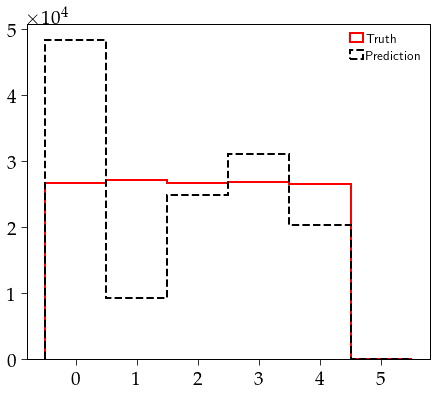

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(qstest[label], color="r", ls="-", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Truth")
plt.hist(pred, color="k", ls="--", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Prediction")
plt.legend(loc="upper right");

In [14]:
relcols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]
cols = [col + "_norm" for col in relcols]
print cols

pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(cols)),
         ("poly", PolynomialFeatures(degree=2)),
         ("ranforest", RandomForestClassifier(n_estimators=30, n_jobs=-1))
#          ("knn", KNeighborsRegressor(n_neighbors=a))
#          ("svc", LinearSVC())
#          ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=False), RandomForestRegressor(n_estimators=15)))
#          ("multi", MultiModelRegressor(SGDRegressor(), RandomForestRegressor(n_estimators=20)))
    ])

pipe_feat = pipe_feat_fct(100)

['BodyNCodes_norm', 'BodyNQMarks_norm', 'BodySize_norm', 'titlelen_norm', 'nwords_norm', 'ordersum_norm', 'ordermean_norm', 'orderstd_norm', 'ratio_norm']


In [23]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

In [ ]:
for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

In [15]:
pipe_feat.fit(qstrain, qstrain[label])
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_feat.score(qstest, qstest[label])

[[2 1]
 [0 0]
 [4 4]
 ..., 
 [0 2]
 [1 4]
 [4 3]]
0.250022460181


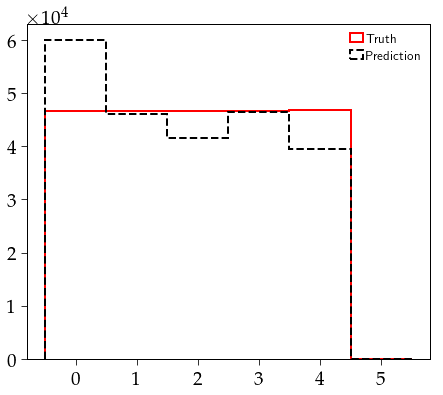

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(qstest[label], color="r", ls="-", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Truth")
plt.hist(pred, color="k", ls="--", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Prediction")
plt.legend(loc="upper right");

In [17]:
comp = pd.DataFrame({"truth": qstest[label], "pred": pred})
comp = comp.groupby(["truth", "pred"]).apply(len)
comp = comp.unstack(level=-1)

# normalization
comp = comp * 1. / comp.apply(np.sum, axis=1)
comp.sort_index(ascending=False, inplace=True)
# comp = comp * 1. / comp.groupby("truth").apply(sum, axis=0)
print comp

pred          0         1         2         3         4
truth                                                  
4      0.216801  0.177637  0.175486  0.221021  0.212239
3      0.178804  0.175239  0.194445  0.265324  0.185672
2      0.232972  0.198792  0.188924  0.214344  0.164776
1      0.288832  0.215408  0.179531  0.169442  0.146055
0      0.368446  0.218706  0.152654  0.124262  0.135011


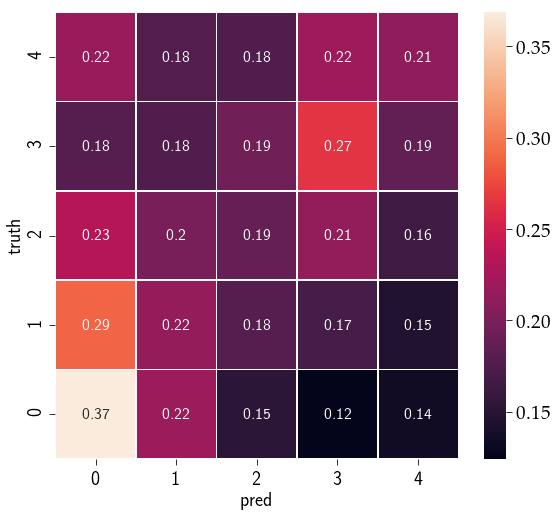

In [18]:
import seaborn as sns
plt.figure(figsize=(10, 8))
ax = sns.heatmap(comp, annot=True, linewidths=0.5)
plt.savefig("./plots/heatmap_naive.pdf")

In [14]:
pipe_tags = Pipeline([
                     ("cst", ColumnSelectTransformer(["Tags"])),
                     ("dec", DictEncoder("Tags")),
                     ("dvec", DictVectorizer(sparse=True)),
                     ("tfid", TfidfTransformer()),
                     ("ranforest", RandomForestClassifier(n_estimators=20, n_jobs=-1))
                     ])

In [15]:
pipe_tags.fit(qstrain, qstrain[label])
pred = pipe_tags.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_tags.score(qstest, qstest[label])

[[4 1]
 [0 0]
 [3 2]
 ..., 
 [2 1]
 [1 0]
 [3 2]]
0.298023076232


In [16]:
comp = pd.DataFrame({"truth": qstest[label], "pred": pred})
comp = comp.groupby(["truth", "pred"]).apply(len)
comp = comp.unstack(level=-1)

# normalization
comp = comp * 1. / comp.apply(np.sum, axis=1)
comp.sort_index(ascending=False, inplace=True)
# comp = comp * 1. / comp.groupby("truth").apply(sum, axis=0)
print comp

pred          0         1         2         3         4
truth                                                  
4      0.206514  0.141970  0.160180  0.274217  0.220652
3      0.115067  0.122307  0.196780  0.374116  0.187924
2      0.214423  0.181550  0.219277  0.234137  0.147499
1      0.341469  0.211247  0.177568  0.144301  0.126732
0      0.464785  0.201362  0.128990  0.095685  0.111232


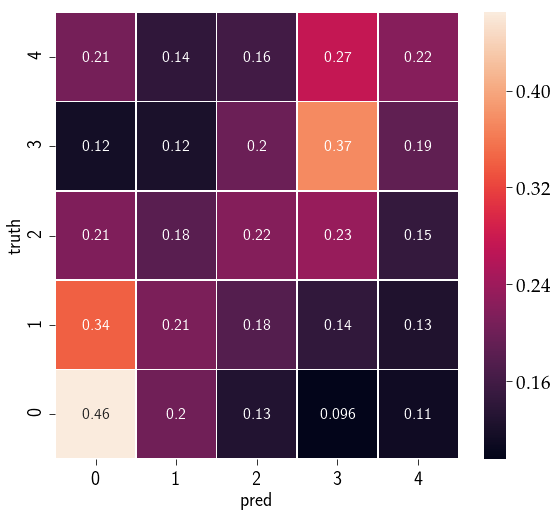

In [17]:
import seaborn as sns
plt.figure(figsize=(10, 8))
ax = sns.heatmap(comp, annot=True, linewidths=0.5)
plt.savefig("./plots/heatmap_tags.pdf")

In [31]:
qstrain.Title.head()

945097    PHP - Get multiple newest files with exact mod...
475970          Seeing leaks when using an NSCollectionView
685804    Sqlite: How to select a value from a table whe...
366968                         C++ BigInteger to byte array
406381      Load applet resources with size more than 40 MB
Name: Title, dtype: object

In [20]:
pipe_titles = Pipeline([
                     ("cst", ColumnSelectTransformer(["Title"])),
                     ("tfid", TfidfVectorizer(ngram_range=(1, 3), stop_words="english")),
                     ("ranforest", RandomForestClassifier(n_estimators=20, n_jobs=-1))
                     ])

In [ ]:
pipe_titles.fit(qstrain, qstrain[label])
pred = pipe_titles.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_titles.score(qstest, qstest[label])

In [ ]:
comp = pd.DataFrame({"truth": qstest[label], "pred": pred})
comp = comp.groupby(["truth", "pred"]).apply(len)
comp = comp.unstack(level=-1)

# normalization
comp = comp * 1. / comp.apply(np.sum, axis=1)
comp.sort_index(ascending=False, inplace=True)
# comp = comp * 1. / comp.groupby("truth").apply(sum, axis=0)
print comp

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
ax = sns.heatmap(comp, annot=True, linewidths=0.5)
plt.savefig("./plots/heatmap_titles.pdf")

In [18]:
pipe_words = Pipeline([
                      ("cst", ColumnSelectTransformer(["hot_indices"])),
                      ("dec", DictEncoder("hot_indices")),
                      ("dvec", DictVectorizer(sparse=True)),
                      ("tfid", TfidfTransformer()),
#                       ("ridge", Ridge(alpha=2.0))
#                       ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=15)))
#                       ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=True), MLPRegressor(hidden_layer_sizes=(50, 50))))
                      ("mlp", MLPRegressor(hidden_layer_sizes=(100, 100)))
                      ])

In [19]:
pipe_words.fit(qstrain, qstrain[label])
pred = pipe_words.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_words.score(qstest, qstest[label])

[[ 0.11661578  1.73275229]
 [-0.68789848  1.62309463]
 [-0.41625747  0.56544562]
 ..., 
 [-0.95755484 -2.74837232]
 [-0.66469107 -2.45769623]
 [-0.03610053 -1.2427968 ]]
0.0427342687598


In [90]:
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([
                     ("tags", EstimatorTransformer(pipe_tags)),
                     ("words", EstimatorTransformer(pipe_words)),
                     ("feat", EstimatorTransformer(pipe_feat))
                     ])

pipe_combined = Pipeline([
                    ("union", union),
                    ("ridge", Ridge(alpha=3.0))
                    # ("comb", CustomCombiner())
                    ])

In [92]:
pipe_combined.fit(qstrain, qstrain[label])
pred = pipe_combined.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_combined.score(qstest, qstest[label])

Performing base regression...
Performing residual regression...
Performing base regression...
Performing residual regression...
[[-1.38131283 -1.24080278]
 [ 2.58146676  2.53918837]
 [-1.48334503 -2.46557472]
 ..., 
 [-0.68950884 -2.54889492]
 [ 0.51332501 -1.11581542]
 [ 1.50734924  3.57332448]]
0.461645944995


In [93]:
import dill

In [94]:
dill.dump(pipe_combined, open("pipe_feat.dill", "w"))

In [ ]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))